In [1]:
import os
import numpy as np
from pycocotools import mask
from PIL import Image
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def annotations_converter(coco_annotation_path, image_dir, binary_mask_dir):
    with open(coco_annotation_path, 'r') as f:
        data = json.load(f)

    for img in data['images']:
        img_id = img['id']
        file_name = img['file_name']
        image_path = os.path.join(image_dir, file_name)
        binary_mask_path = os.path.join(binary_mask_dir, file_name)

        height = img['height']
        width = img['width']

        mask_arr = np.zeros((height, width), dtype=np.uint8)

        anns = [ann for ann in data['annotations'] if ann['image_id'] == img_id]
        #print (anns)
        for ann in anns:
            #print (ann['segmentation'])
            rle = mask.frPyObjects(ann['segmentation'], height, width )
            mask_obj = mask.decode(rle)
            #print (mask_obj.shape)
            #mask_obj = mask.decode(ann['segmentation'])
            mask_arr += np.squeeze(mask_obj) #mask_obj

        mask_arr = np.where(mask_arr > 0, 255, 0).astype(np.uint8)

        Image.fromarray(mask_arr).save(binary_mask_path)

In [3]:
parent_dir = "dataset/"
image_dir = parent_dir+"/images"
coco_json_path = parent_dir+"/annotation/car_dataset_coco_annotation.json"
binary_mask_dir = parent_dir+"/segmented_masks/"

In [4]:
import cv2

In [5]:

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])
 
img_files = os.listdir (image_dir)

for file in img_files:
    img_file = os.path.join (image_dir, file)
    im = cv2.imread(img_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.
     
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])
       
mean = (mean/len (img_files))
print ("Mean of the training data : ", mean)

Mean of the training data :  [0.45753578 0.47372107 0.4908264 ]


In [6]:
for file in img_files:
    img_file = os.path.join (image_dir, file)
    im = cv2.imread(img_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += ((im[:,:,j] - mean[j])**2).sum()/(im.shape[0]*im.shape[1])

std = np.sqrt(stdTemp/len (img_files))
print ("Standard Deviation of the training data : ", std)

Standard Deviation of the training data :  [0.24907104 0.2445758  0.25204785]


In [7]:
#annotations_converter(coco_json_path, image_dir, binary_mask_dir)

In [8]:

class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform=None, mask_transform =None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        #print (self.images)
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        #print (img_path, mask_path)
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            

        #mask = transforms.ToTensor()(mask)
        #mask[mask > 0.5] = 1
        #mask[mask <= 0.5] = 0

        return img, mask


In [9]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.RandomRotation (10),
    transforms.Normalize(mean, std),
    #transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.RandomRotation (10),
    #transforms.ToTensor(),
])

dataset = CarDataset(image_dir, binary_mask_dir , img_transform, mask_transform)


In [10]:
import random
import math
from torch.utils.data import Subset, DataLoader

In [11]:
train_ratio = 0.8
test_ratio = 0.1
valid_ratio = 0.1
batch_size = 8

In [12]:

dataset_size = len(dataset)
train_size = math.floor(dataset_size * train_ratio)
test_size = math.floor(dataset_size * test_ratio)
valid_size = dataset_size - train_size - test_size

print ("num of train samples : ", train_size)
print ("num of test samples : ", test_size)
print ("num of valid samples : ", valid_size)

num of train samples :  99
num of test samples :  12
num of valid samples :  13


In [13]:
indices = list(range(dataset_size))
random.shuffle(indices)

In [14]:

train_indices = indices[:train_size]
test_indices = indices[train_size:train_size+test_size]
valid_indices = indices[train_size+test_size:]
print (train_indices)
print (test_indices)
print (valid_indices)

[36, 73, 95, 15, 118, 119, 88, 39, 120, 17, 13, 93, 12, 81, 80, 14, 116, 0, 61, 92, 24, 5, 58, 55, 59, 51, 67, 47, 16, 109, 23, 45, 115, 19, 21, 74, 65, 8, 97, 41, 78, 106, 76, 104, 31, 82, 22, 117, 110, 28, 25, 66, 122, 96, 42, 50, 29, 71, 105, 35, 100, 18, 83, 84, 101, 99, 86, 53, 32, 123, 38, 3, 102, 77, 107, 4, 70, 34, 7, 79, 56, 1, 62, 98, 2, 91, 11, 64, 94, 90, 33, 26, 37, 20, 40, 60, 69, 63, 111]
[44, 48, 10, 72, 30, 52, 87, 43, 54, 68, 49, 9]
[75, 85, 46, 103, 89, 121, 6, 57, 27, 113, 108, 114, 112]


In [15]:
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
valid_dataset = Subset(dataset, valid_indices)

In [16]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [17]:
batch_size = 2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


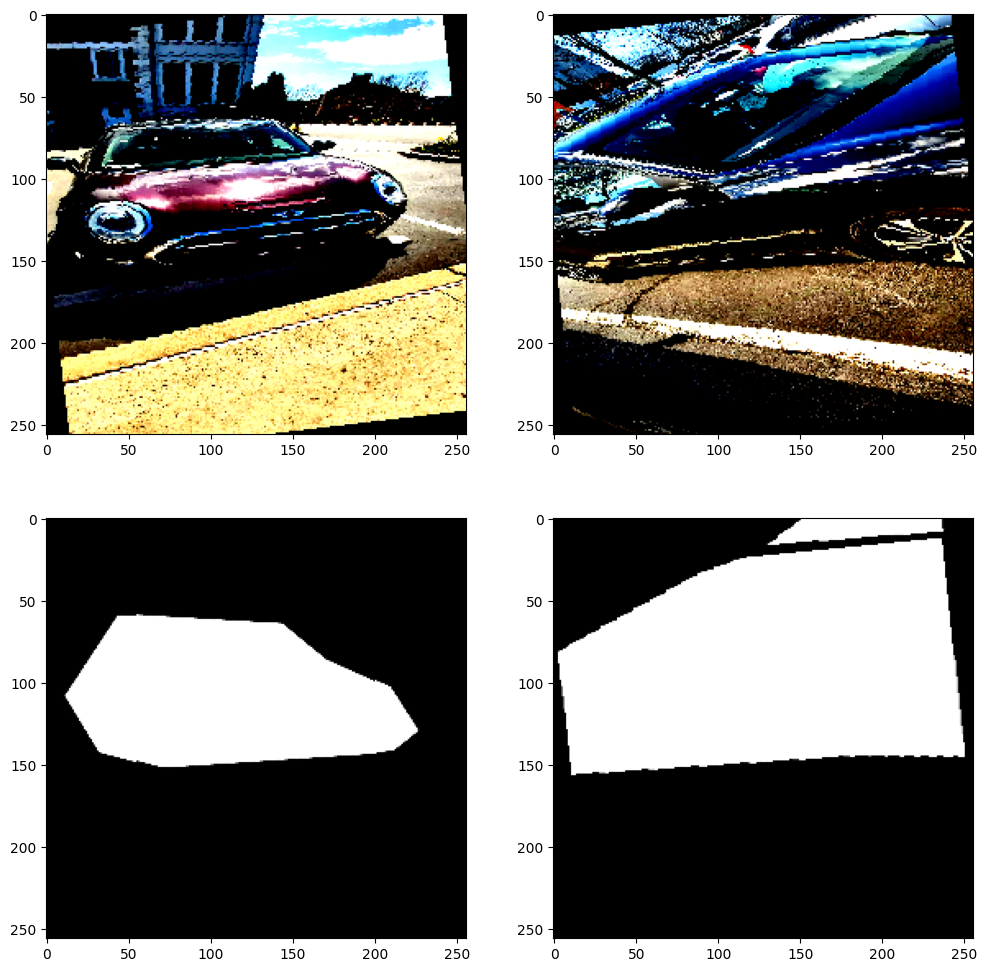

In [18]:
import matplotlib.pyplot as plt

# Get a batch of data from the data loader
inputs, masks = next(iter(data_loader))

# Plot the input images and masks
fig, axs = plt.subplots(batch_size, batch_size, figsize=(12, 12))
for i in range(batch_size):
    axs[0, i].imshow(inputs[i].permute(1, 2, 0))
    axs[1, i].imshow(masks[i].squeeze(), cmap='gray')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


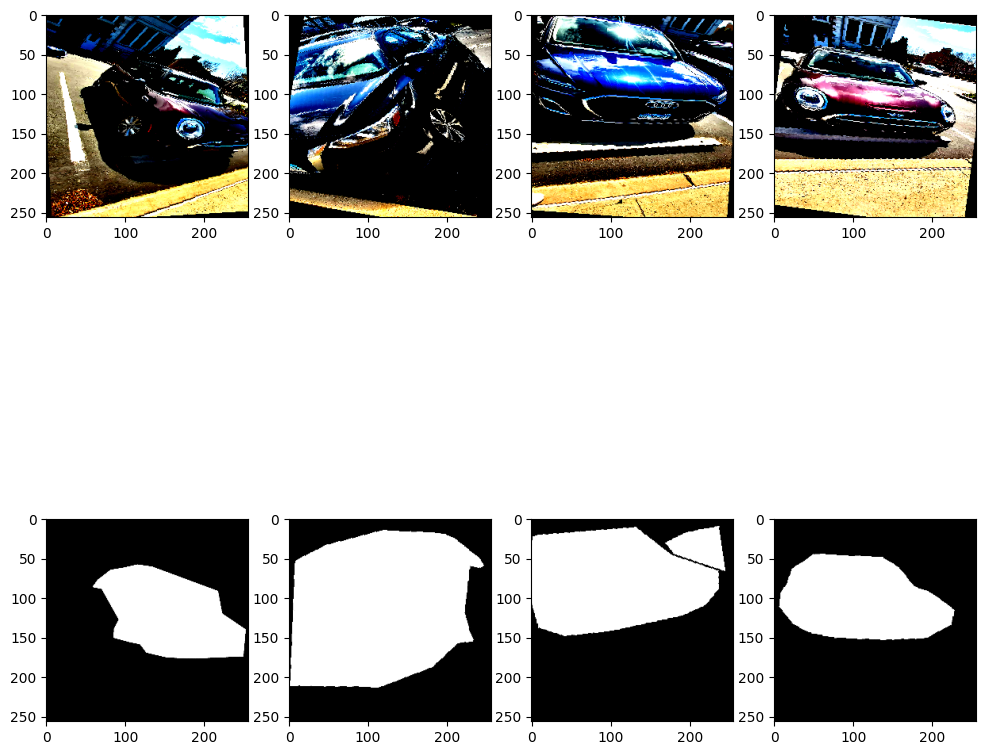

In [19]:
# Get a batch of data from the train data loader
inputs, masks = next(iter(train_loader))

# Plot the input images and masks
fig, axs = plt.subplots(2,4, figsize=(12, 12))
for i in range(4):
    axs[0, i].imshow(inputs[i].permute(1, 2, 0))
    axs[1, i].imshow(masks[i].squeeze(), cmap='gray')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


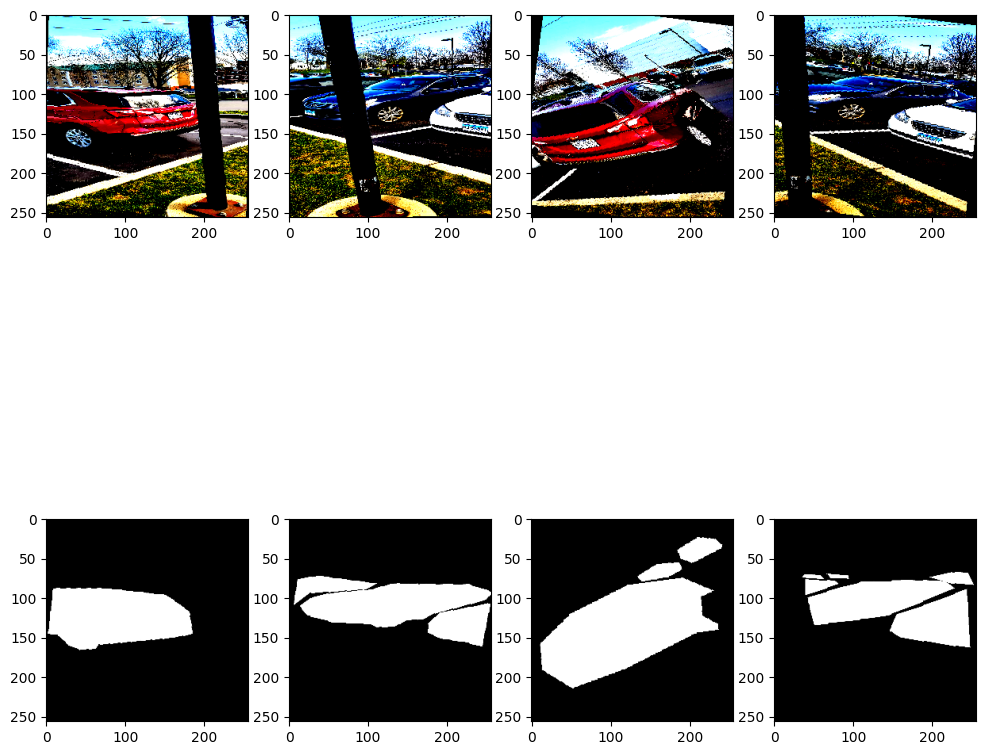

In [20]:
# Get a batch of data from the test data loader
inputs, masks = next(iter(test_loader))

# Plot the input images and masks
fig, axs = plt.subplots(2,4, figsize=(12, 12))
for i in range(4):
    axs[0, i].imshow(inputs[i].permute(1, 2, 0))
    axs[1, i].imshow(masks[i].squeeze(), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


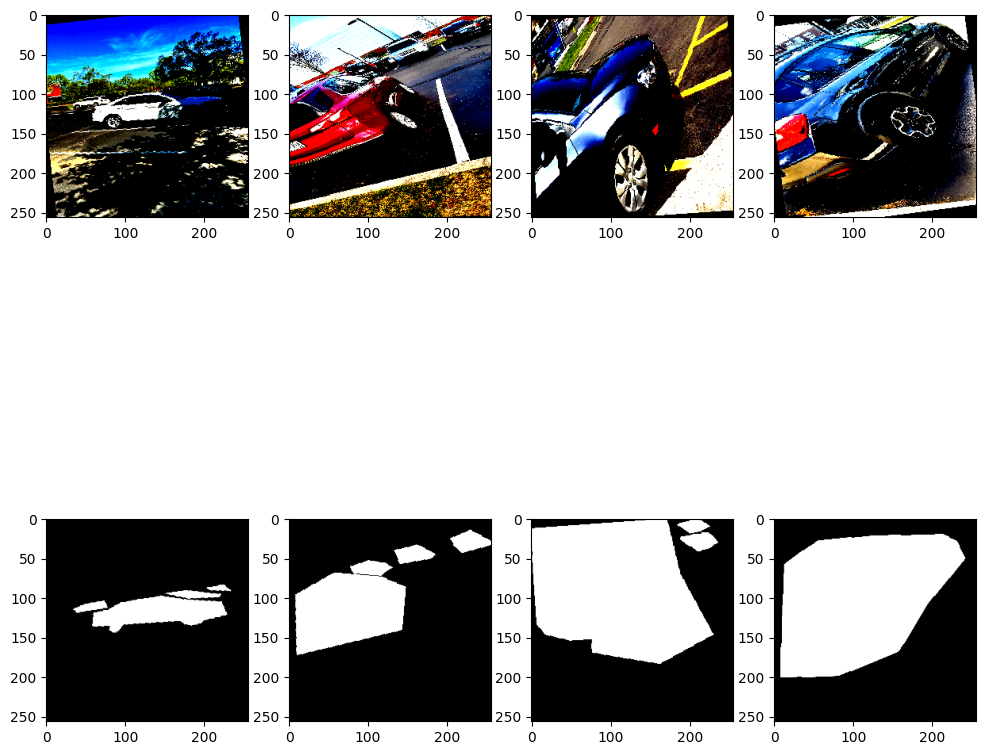

In [21]:
# Get a batch of data from the validation data loader
inputs, masks = next(iter(valid_loader))

# Plot the input images and masks
fig, axs = plt.subplots(2,4, figsize=(12, 12))
for i in range(4):
    axs[0, i].imshow(inputs[i].permute(1, 2, 0))
    axs[1, i].imshow(masks[i].squeeze(), cmap='gray')
plt.show()

In [22]:
import segmentation_models_pytorch as smp


In [23]:

ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car'] 

model = smp.PSPNet(
    encoder_name="resnext50_32x4d", 
    encoder_weights="imagenet", 
    classes=len(CLASSES), 
    activation="sigmoid",
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [24]:

epochs = 10
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)


In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [26]:
model

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [27]:
%%time

best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, epochs):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['iou_score']:
        best_iou_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s, dice_loss - 0.5739, iou_score - 0.4746]
Model saved!

Epoch: 1
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s, dice_loss - 0.4274, iou_score - 0.5677]
Model saved!

Epoch: 2
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s, dice_loss - 0.3551, iou_score - 0.5671]

Epoch: 3
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s, dice_loss - 0.3034, iou_score - 0.5985]
Model saved!

Epoch: 4
valid: 100%|███████████████████████████████████████████████████████████████████████████████████

In [28]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=device)
    print('Loaded PSPNet model from this run.')


Loaded PSPNet model from this run.


In [29]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [30]:
# helper function for data visualization
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        
        plt.title(name.replace('_',' ').title(), fontsize=20)
        #plt.imshow(image)
        plt.imshow(image.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


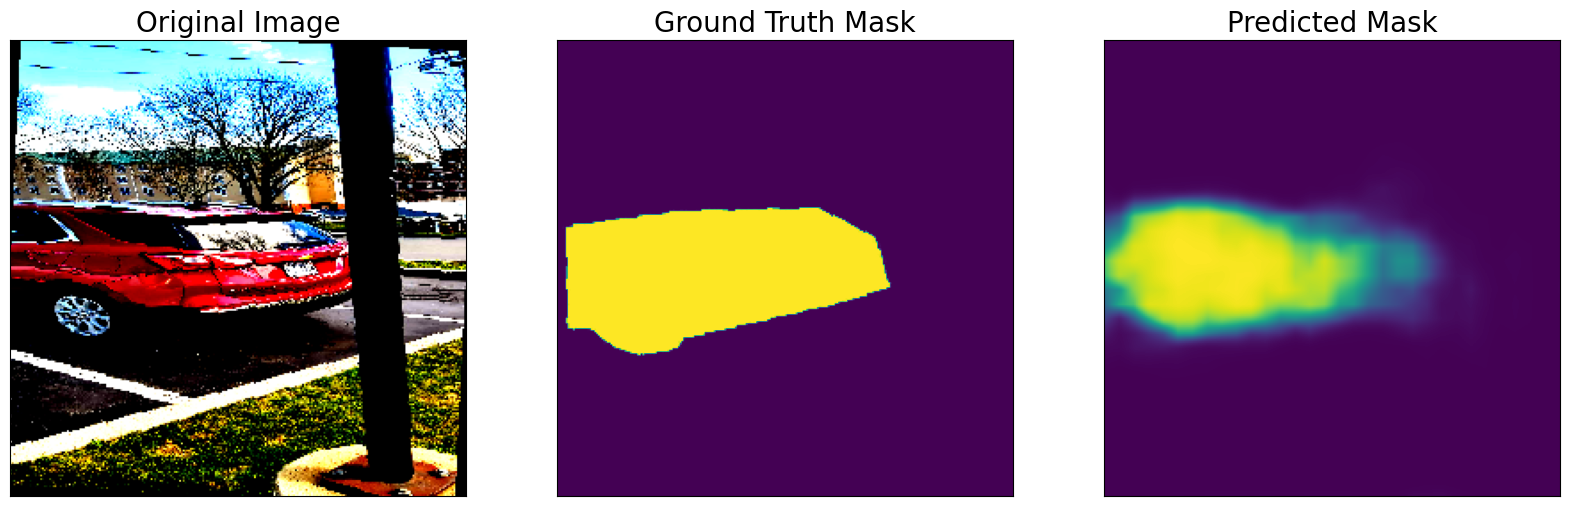

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


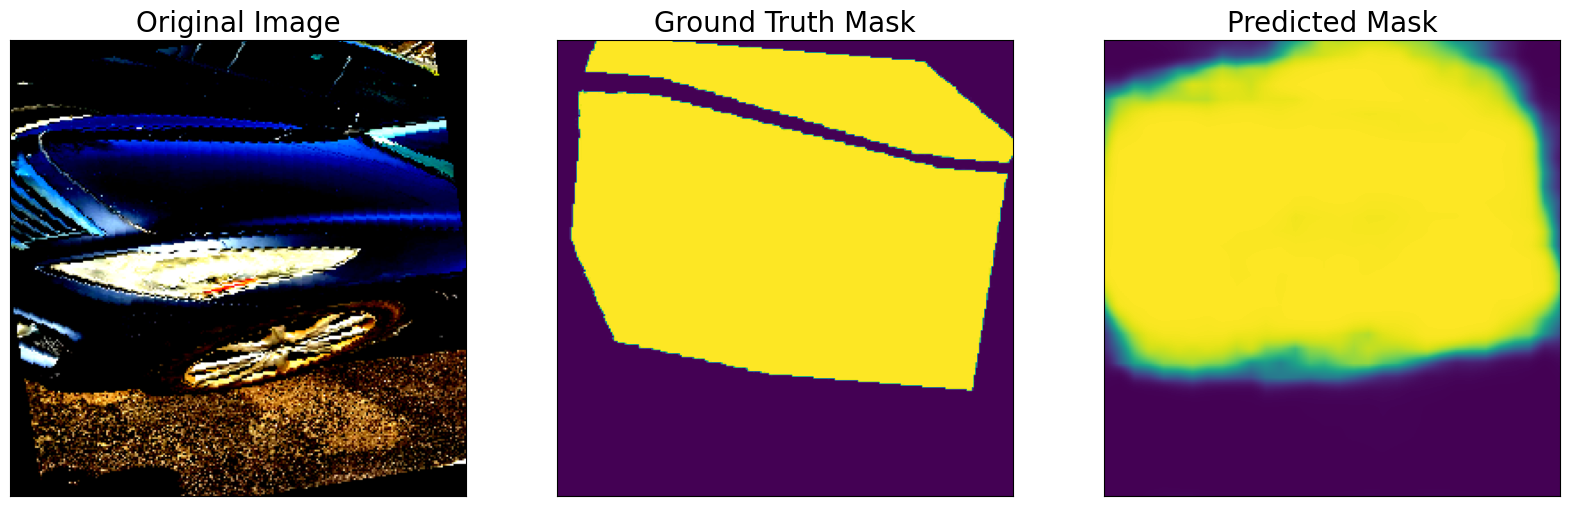

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


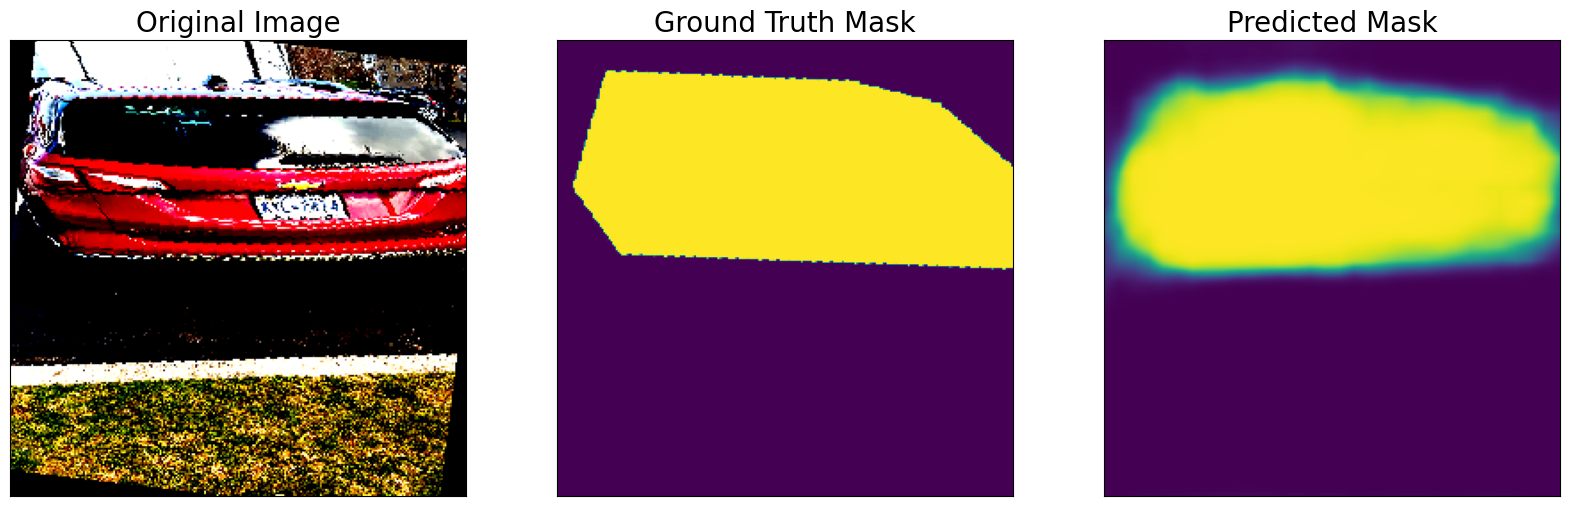

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


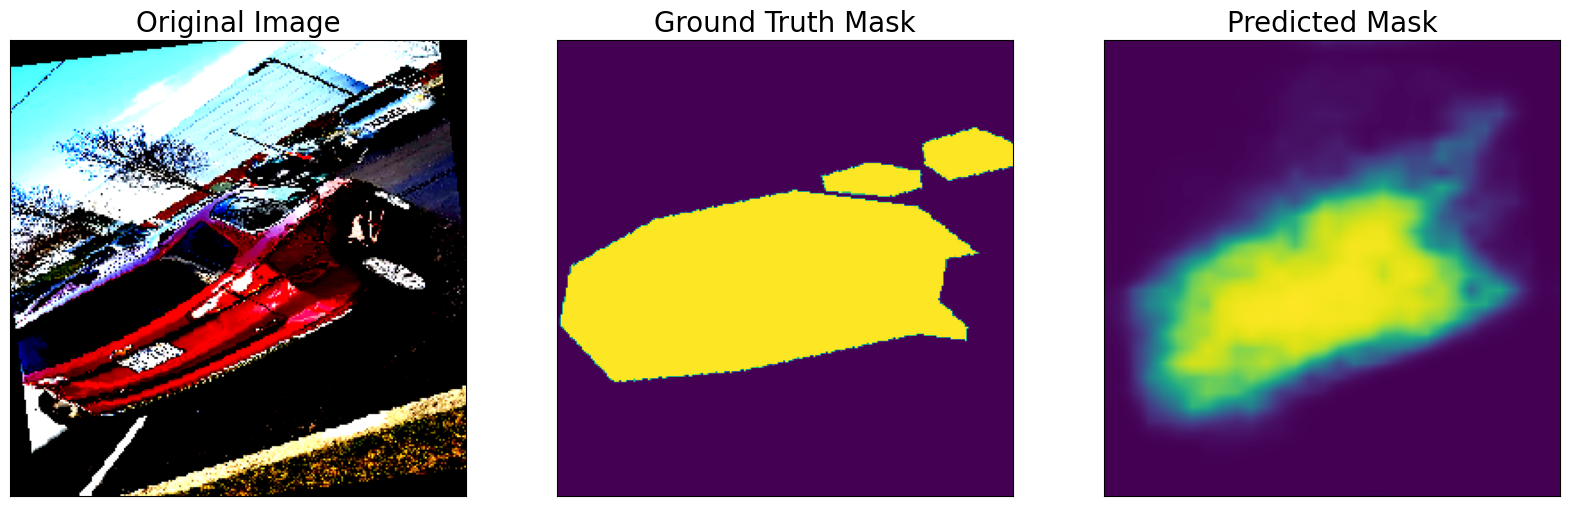

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


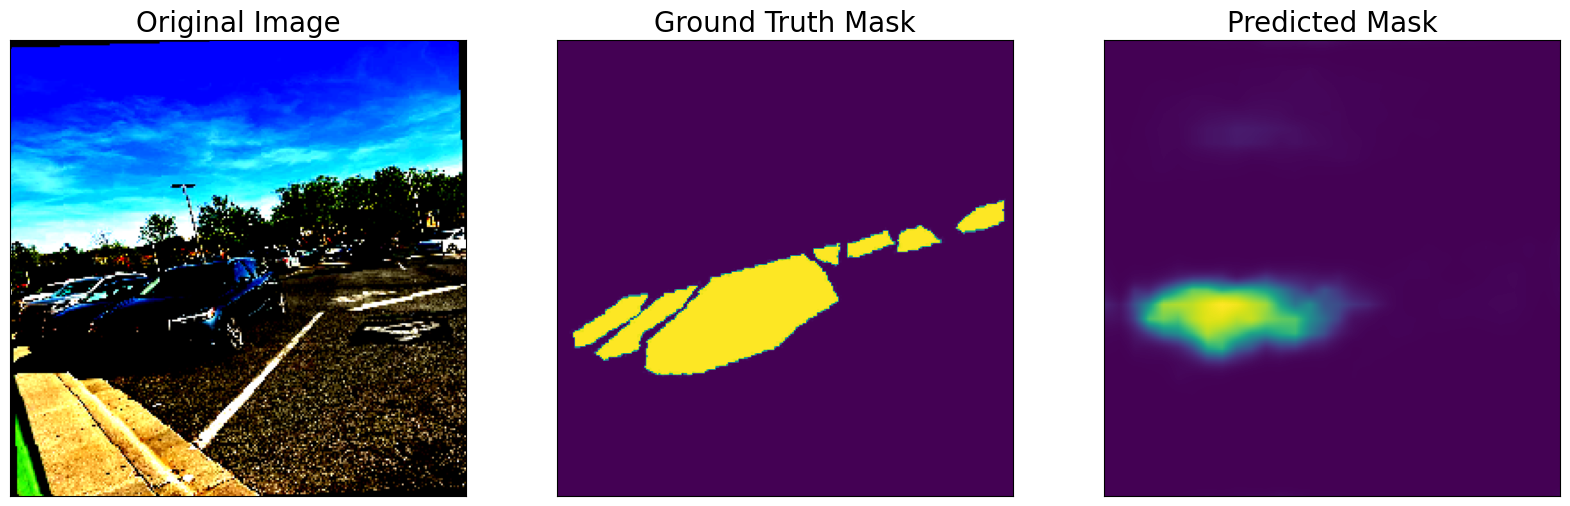

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


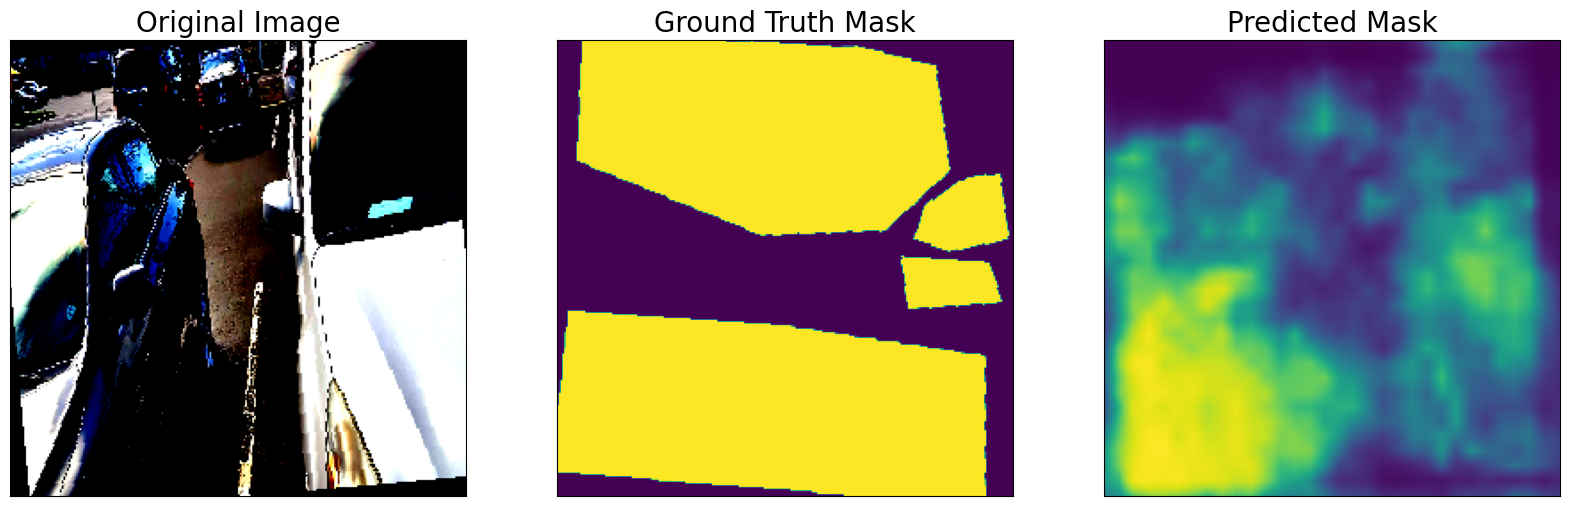

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


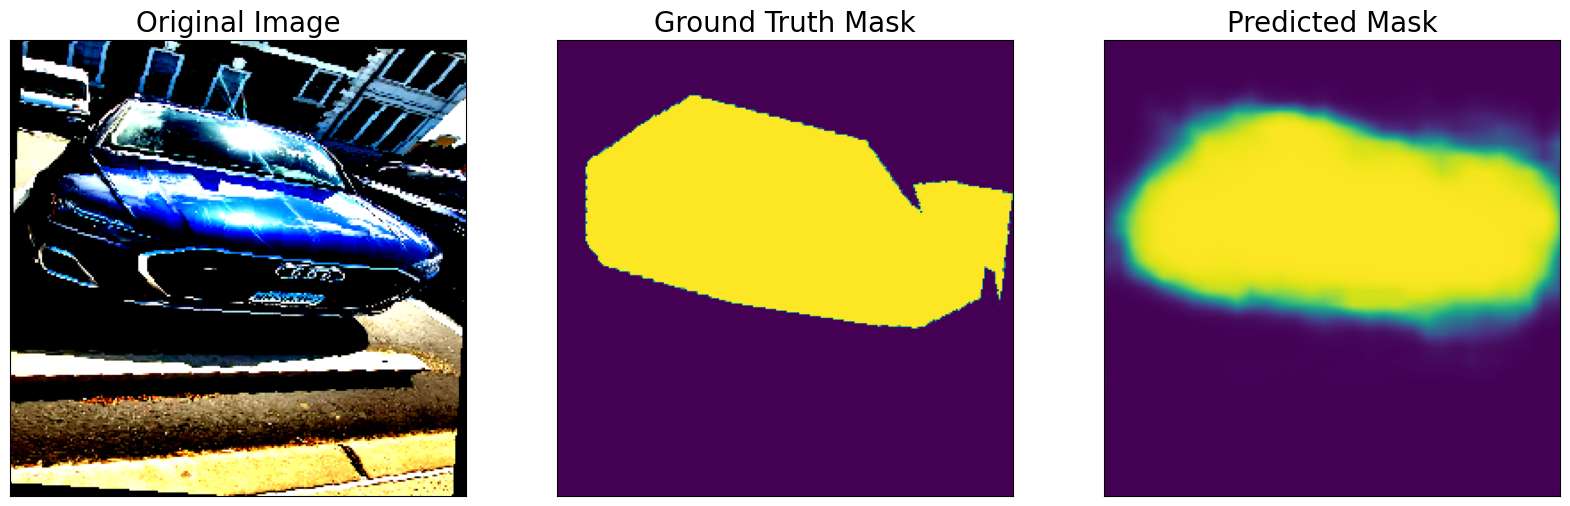

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


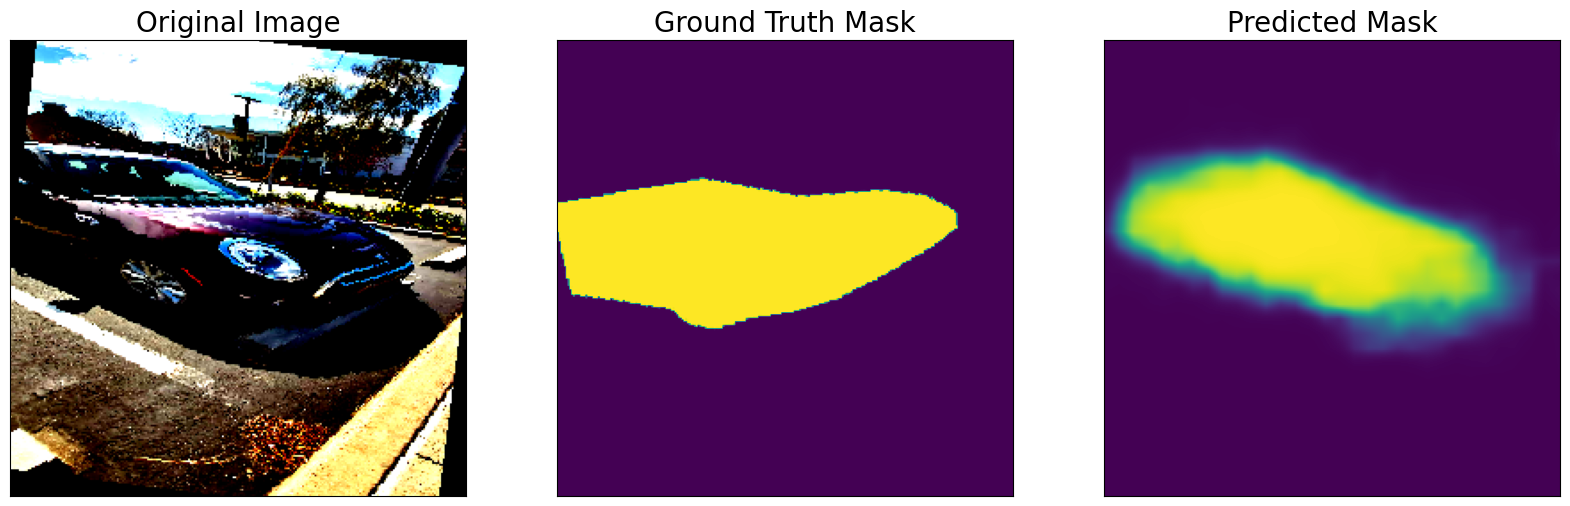

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


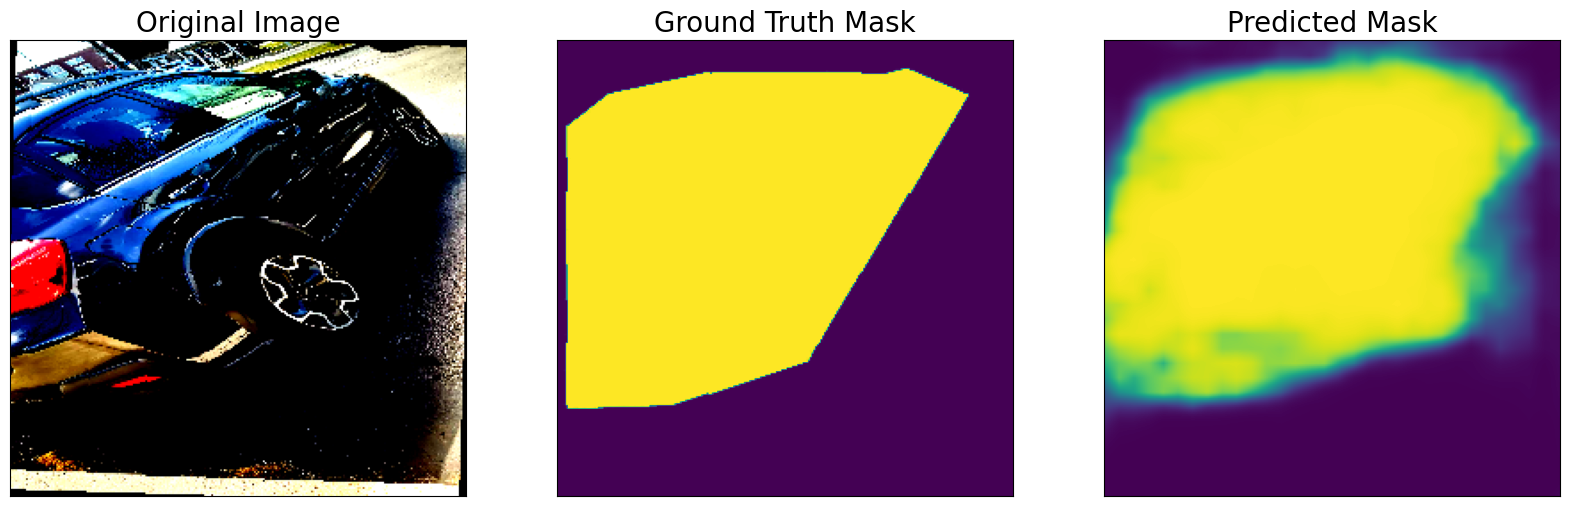

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


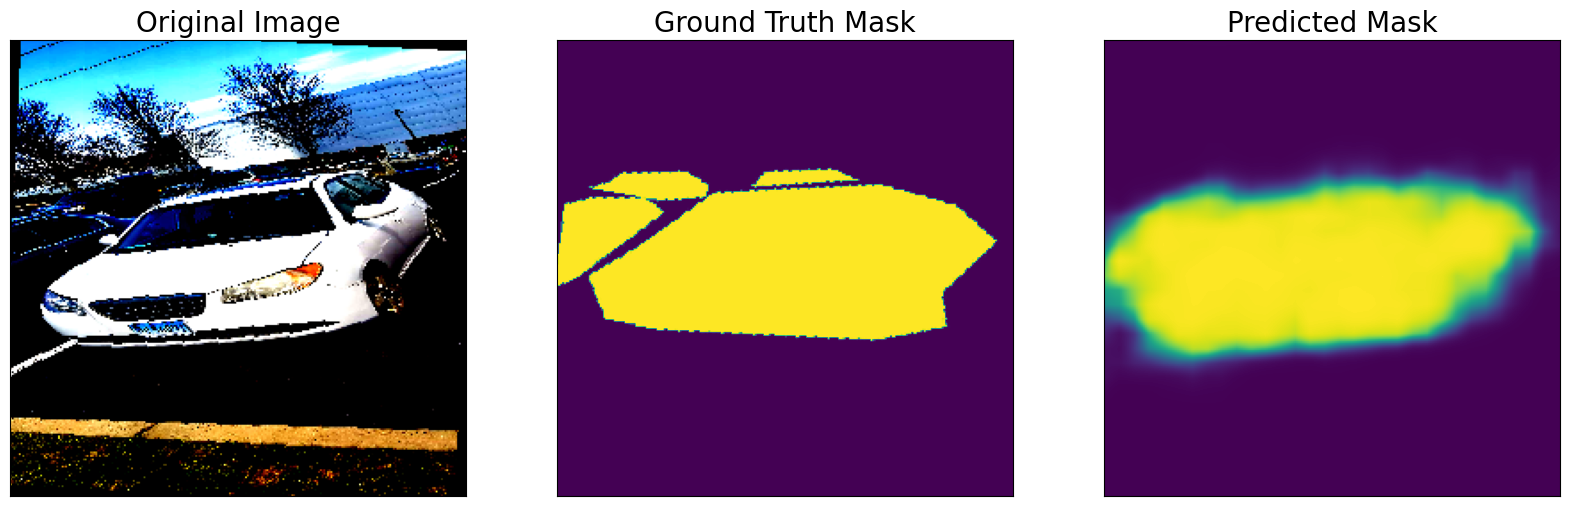

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


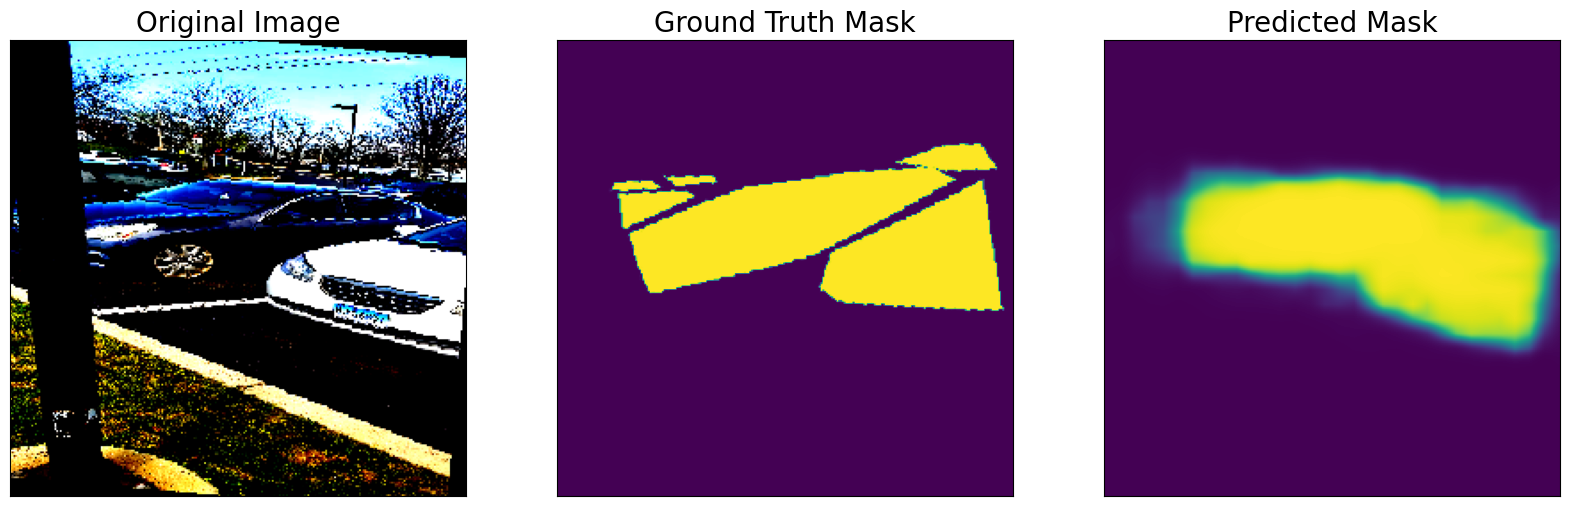

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


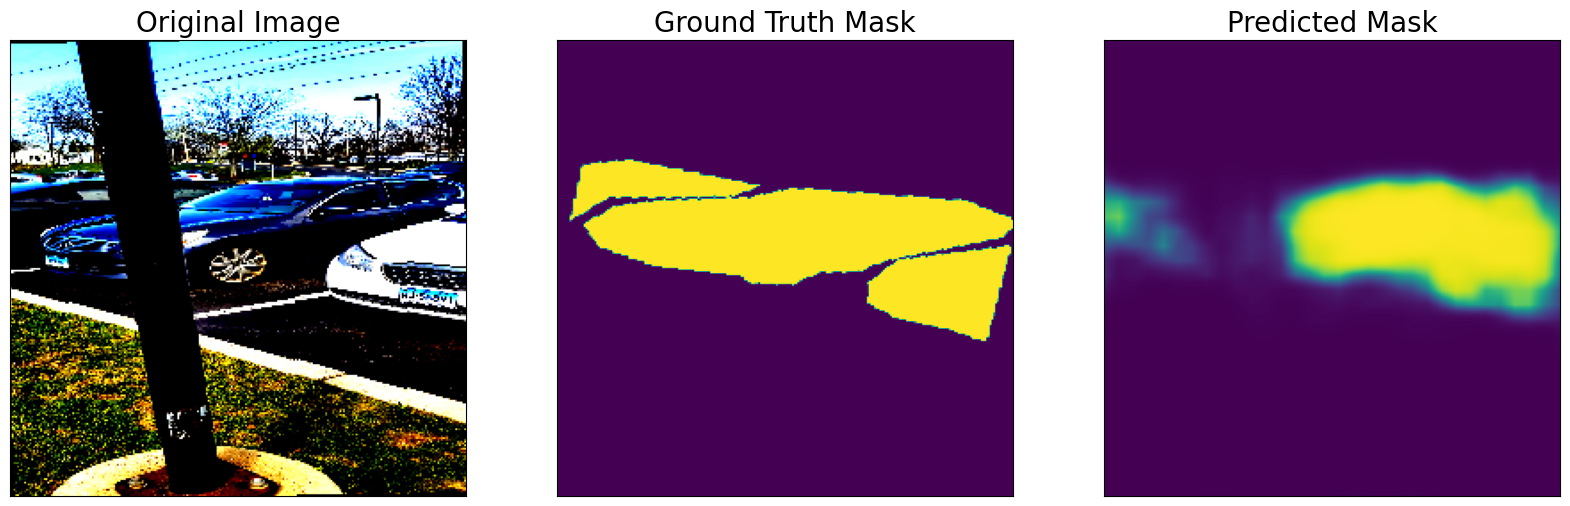

In [31]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]

    x_tensor = image.to(device).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze(dim=1)
    
    #plt.imshow (pred_mask)
    print (image.shape, gt_mask.shape, pred_mask.shape)
    #cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image, gt_mask, pred_mask])[:,:,::-1])

    visualize(original_image = image, ground_truth_mask = gt_mask, predicted_mask = pred_mask) #predicted_mask = pred_mask)


In [32]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

valid_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.30it/s, dice_loss - 0.1755, iou_score - 0.7386]
Evaluation on Test Data: 
Mean IoU Score: 0.7386
Mean Dice Loss: 0.1755


In [33]:
import pandas as pd
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4         5  \
dice_loss  0.452219  0.320572  0.268061  0.220371  0.198002  0.184317   
iou_score  0.428885  0.545423  0.605875  0.682982  0.710349  0.729308   

                  6         7         8         9  
dice_loss  0.165200  0.167830  0.151847  0.137563  
iou_score  0.747291  0.742373  0.765563  0.784953

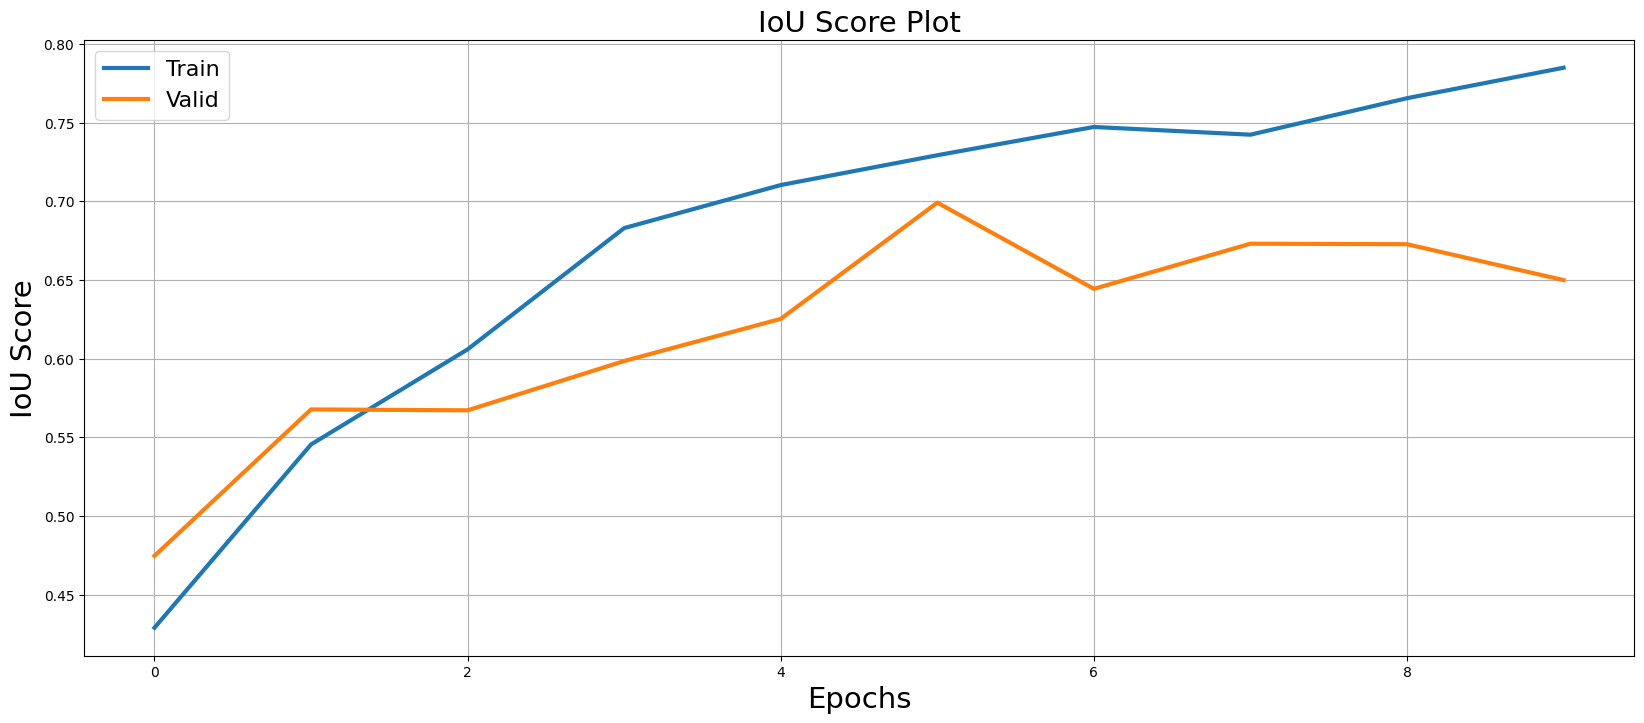

In [34]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

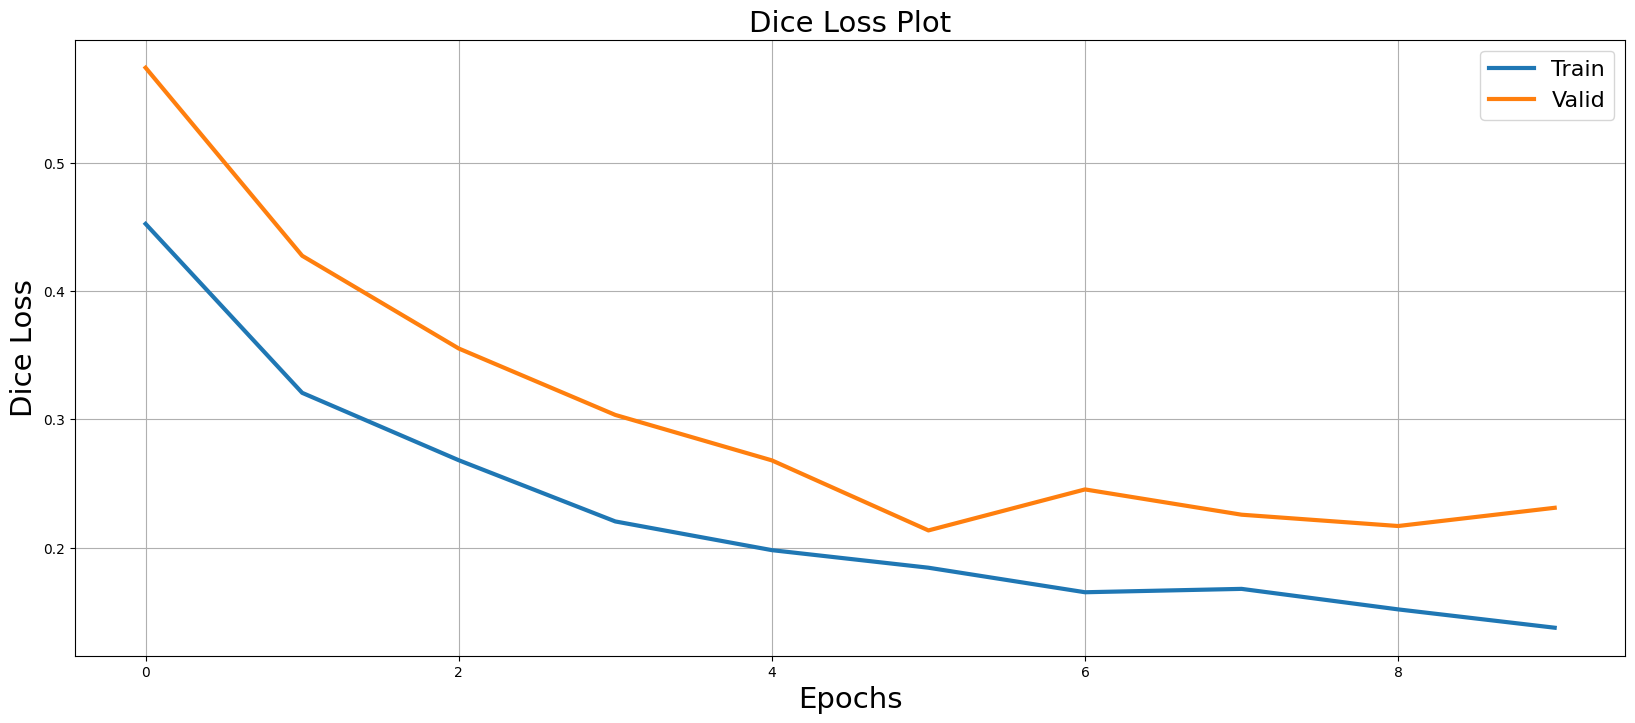

In [35]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()